In [2]:
import sys
import os
sys.path.insert(0,os.path.expanduser('~/git/torchseg'))
print(sys.path)

os.chdir(os.path.expanduser('~/git/torchseg'))
from utils.augmentor import get_default_augmentor_config, Augmentations
from utils.disc_tools import show_images
from easydict import EasyDict as edict

['/data02/jiaxin15/git/torchseg', '', '/data02/jiaxin15/git/torchseg/notebooks', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python36.zip', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/lib-dynload', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/Sphinx-1.6.3-py3.6.egg', '/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/IPython/extensions', '/data02/jiaxin15/.ipython']


/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


(1024, 2048, 3) (1024, 2048)
(416, 833, 3) (416, 833)


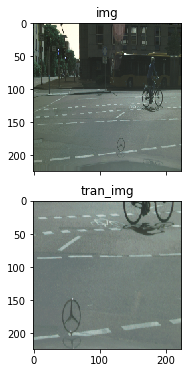

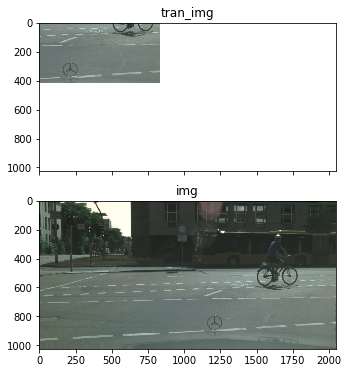

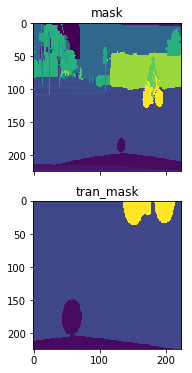

In [12]:
import matplotlib.pyplot as plt
def show_images(images,titles=None,vmin=None,vmax=None):
    fig, axes = plt.subplots(2, (len(images)+1)//2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(len(images)):
        ax[i].imshow(images[i],vmin=vmin,vmax=vmax)
        if titles is None:
            ax[i].set_title("image %d"%i)
        else:
            ax[i].set_title(titles[i])

    plt.show()
    

config = get_default_augmentor_config()
config.aug.keep_crop_ratio=False
config.aug.use_rotate=False
config.aug.min_crop_size=[400,800]
config.aug.max_crop_size=[500,1000]
config.aug.crop_size_step=0
config.aug.pad_for_crop=True
config.aug.use_debug=True
config.aug.horizontal_flip=False
config.dataset=edict()
config.dataset.ignore_index=255
aug = Augmentations(config)
img = cv2.imread('test/image.png', cv2.IMREAD_COLOR)
mask = cv2.imread('test/mask.png', cv2.IMREAD_GRAYSCALE)
#    img=np.random.rand(60,80)
#    mask=np.random.rand(60,80)

assert img is not None
assert mask is not None

tran_img, tran_mask = aug.transform(img, mask)
assert tran_img is not None
assert tran_mask is not None
print(img.shape,mask.shape)
print(tran_img.shape,tran_mask.shape)

imgs = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR) for img in [img, tran_img]]
masks = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST) for img in [mask, tran_mask]]
show_images(imgs, ['img', 'tran_img'])
show_images([tran_img,img],['tran_img','img'])
show_images(masks, ['mask','tran_mask'], vmin=0,vmax=33)

In [5]:
print(np.unique(tran_mask))

[ 7  8 11 25 28 33]


In [16]:
mask.shape
print(mask[700,100])
print(mask[1023,0])
print(mask[1023,2040])
print(tran_mask[400,0])

7
3
3
7


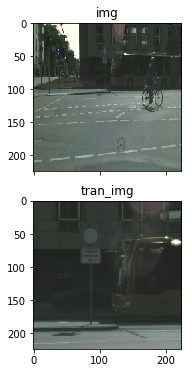

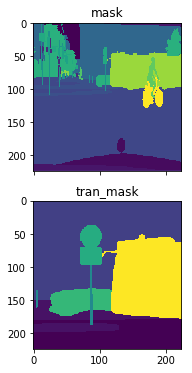

In [26]:
imgs = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR) for img in [img, tran_img]]
masks = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST) for img in [mask, tran_mask]]
show_images(imgs, ['img', 'tran_img'])
show_images(masks, ['mask','tran_mask'])

In [9]:
from easydict import EasyDict as edict
import os
from dataset.fbms_dataset import fbms_dataset
from dataset.cdnet_dataset import cdnet_dataset
from dataset.segtrackv2_dataset import segtrackv2_dataset
from dataset.bmcnet_dataset import bmcnet_dataset
import matplotlib.pyplot as plt
import unittest
import cv2
from tqdm import trange

def get_dataset(config,split,normer=None,augmentations=None):
    if config.dataset=='FBMS':
        config['root_path']=os.path.expanduser('~/cvdataset/FBMS')
    elif config.dataset=='cdnet2014':
        config['root_path']=os.path.expanduser('~/cvdataset/cdnet2014')
    elif config.dataset=='segtrackv2':
        config['root_path']=os.path.expanduser('~/cvdataset/SegTrackv2')
    elif config.dataset=='BMCnet':
        config['root_path']=os.path.expanduser('~/cvdataset/BMCnet')
    else:
        assert False

    if config.dataset=='FBMS':
        xxx_dataset=fbms_dataset(config,split,normalizations=normer,augmentations=augmentations)
    elif config.dataset=='cdnet2014':
        xxx_dataset=cdnet_dataset(config,split,normalizations=normer,augmentations=augmentations)
        print(xxx_dataset.train_set,xxx_dataset.val_set)
    elif config.dataset=='segtrackv2':
        xxx_dataset=segtrackv2_dataset(config,split,normalizations=normer,augmentations=augmentations)
    elif config.dataset=='BMCnet':
        xxx_dataset=bmcnet_dataset(config,split,normalizations=normer,augmentations=augmentations)
    else:
        assert False

    return xxx_dataset

config=edict()
config.dataset='FBMS'
config.frame_gap=0
config.input_shape=(224,224)
config.use_part_number=2000
config.use_optical_flow=False
config.ignore_outOfRoi=True
def test_dataset(config):
    def test_img(p):
        img=cv2.imread(p)
        plt.imshow(img)
        plt.show()

    # 'FBMS','cdnet2014','segtrackv2',
    for dataset in ['BMCnet']:
        config.dataset=dataset
        for split in ['train','val']:
            xxx_dataset=get_dataset(config,split)
            N=len(xxx_dataset)
            for i in trange(N):
                main,aux,gt=xxx_dataset.__get_path__(i)
                for p in [main,aux,gt]:
                    if isinstance(p,str):
                        test_img(p)
                    else:
                        for x in p:
                            test_img(x)
                            
                break       


  0%|          | 0/2142 [00:00<?, ?it/s]

dataset size = {} 14991
total dataset image 14991, use 2142


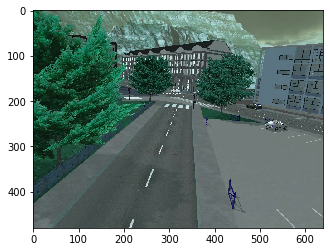

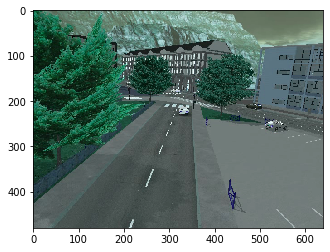

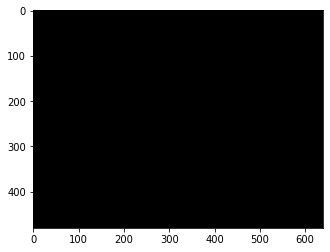



  0%|          | 0/990 [00:00<?, ?it/s]

dataset size = {} 990


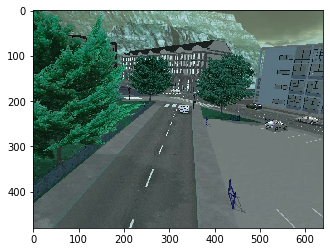

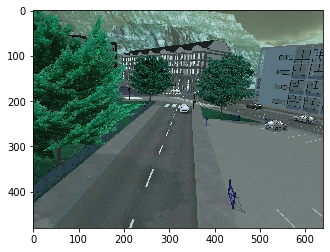

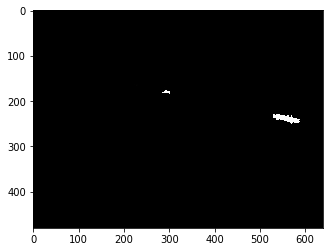

In [10]:
test_dataset(config)